选richhf18k一个小子集的图片100张，用caption和image微调SDXL，然后收敛后用caption去噪，去噪每k个时间步调用gpt4o直接给多个score一次打分（多个一起省token也可以)，然后绘制一个去噪过程中各个reward变化的curve

In [ ]:
# 1. 准备工作：设置 API 密钥和环境
import torch
import openai
from diffusers import StableDiffusionXLImg2ImgPipeline, StableDiffusionXLPipeline, EulerDiscreteScheduler
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import base64
from io import BytesIO
import json
from tqdm import tqdm

# 从 Colab Secrets 加载 API 密钥
# 如果你没有使用 Secrets，请直接在这里赋值
# from google.colab import userdata
# HUGGING_FACE_TOKEN = userdata.get('HUGGING_FACE_TOKEN')
# OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
HUGGING_FACE_TOKEN = "hf_xxxxx"
OPENAI_API_KEY = "sk-proj-xxxxx"

os.environ["HUGGING_FACE_HUB_TOKEN"] = HUGGING_FACE_TOKEN
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

# 检查 GPU 是否可用
if not torch.cuda.is_available():
    raise RuntimeError("GPU 没有找到。请在 Colab 设置中启用 GPU。")
device = "cuda"

print("API 密钥和环境检查完成。")

API 密钥和环境检查完成。


In [2]:
# 2. 数据集与模型加载
print("正在加载数据集...")

from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("Exploration/richhf_18k_with_images")
print(f"数据集加载完成，包含 {len(ds)} 个样本。")

正在加载数据集...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


数据集加载完成，包含 3 个样本。


In [3]:
print("正在加载 SDXL 模型...")

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)
pipe = pipe.to(device)
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
print("模型加载完成。")


正在加载 SDXL 模型...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

模型加载完成。


In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'aesthetics_score', 'artifact_score', 'misalignment_score', 'overall_score', 'artifact_map', 'misalignment_map', 'prompt_misalignment_label', 'image', 'caption'],
        num_rows: 15810
    })
    validation: Dataset({
        features: ['filename', 'aesthetics_score', 'artifact_score', 'misalignment_score', 'overall_score', 'artifact_map', 'misalignment_map', 'prompt_misalignment_label', 'image', 'caption'],
        num_rows: 995
    })
    test: Dataset({
        features: ['filename', 'aesthetics_score', 'artifact_score', 'misalignment_score', 'overall_score', 'artifact_map', 'misalignment_map', 'prompt_misalignment_label', 'image', 'caption'],
        num_rows: 955
    })
})

In [5]:
sample = ds["train"][0]
image = sample['image']

print("--- 数据集图片信息 ---")
print(f"图片字段类型: {type(image)}")
print(f"图片模式 (Mode): {image.mode}")
print(f"图片尺寸 (Size): {image.size}")
print(f"图片格式 (Format): {image.format}")
print("--- 验证完成 ---")

--- 数据集图片信息 ---
图片字段类型: <class 'PIL.JpegImagePlugin.JpegImageFile'>
图片模式 (Mode): RGB
图片尺寸 (Size): (768, 768)
图片格式 (Format): JPEG
--- 验证完成 ---


In [7]:
import random
random.seed(42)  # 设置随机种子以确保可重现
indices = random.sample(range(len(ds["train"])), 100)
subset = ds["train"].select(indices)
print(f"已选择 {len(subset)} 张图片作为训练子集")


已选择 100 张图片作为训练子集


In [8]:
# 3. 数据预处理
def preprocess_data(subset):
    images = []
    captions = []

    for item in tqdm(subset, desc="预处理数据"):
        # 获取图片和标题
        image = item['image']
        caption = item['caption']

        # 确保图片是RGB格式，并调整大小到SDXL标准尺寸
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = image.resize((1024, 1024))

        images.append(image)
        captions.append(caption)

    return images, captions

images, captions = preprocess_data(subset)
print(f"预处理完成，共处理了 {len(images)} 张图片")

预处理数据:   0%|          | 0/100 [00:00<?, ?it/s]

预处理完成，共处理了 100 张图片


In [8]:
captions

['Beautiful Interior dining room black and wood and big colored picture on the wall',
 'a photo of striped cats in the crown of a palm tree',
 'A creative and high-quality hookah with a cannonball-inspired design, featuring intricate details and a unique aesthetic',
 'cyberpunk city, bird view',
 'cursed image of house',
 'A sign that says PICK A PIC',
 'An image of a beautiful woman',
 'Chasing a rainbow, surreal, masterpiece, ,',
 'a sad hedgehog',
 'The word GUY made of baroque gold',
 'a watercolor painting of a cat',
 'cats sleeping together',
 'An astronaut with the LGBT flag on the moon',
 'steampunk cat in a steampunk city',
 'A recycle bin icon, frutiger aero style',
 'ice machine, realistic, sleek, blue lightening, atmospheric',
 'cupcake vulva, macro',
 'a bear chasing a girl',
 'Painting of quantum foam brane chillwave style',
 'a puppy and a kitten in a teacup together',
 'Elon Musk in the showarroom no water',
 'Lego Walter white with a shirt that says Time to Cook',
 'Re

# 有点Bug，我不知道为什么他生成的图片会有中间step黑色的，被NSFW了？

In [19]:
# 5. 去噪过程中的评分函数
def encode_image_to_base64(image):
    """将PIL图片编码为base64格式"""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str

def get_gpt4_scores(images_batch, captions_batch):
    """使用GPT-4o对图片批次进行多维度评分"""
    try:
        # 准备消息内容
        content = [
            {
                "type": "text",
                "text": """请对以下图片进行多维度评分（0-10分）：
1. 美学质量 (aesthetics): 图片的整体美观度
2. 工艺质量 (artifact): 图片的技术质量，是否有明显的瑕疵
3. 对齐度 (alignment): 图片与描述文本的匹配程度
4. 整体质量 (overall): 综合评分

请为每张图片返回JSON格式的评分：
{"image_1": {"aesthetics": 7.5, "artifact": 8.0, "alignment": 6.5, "overall": 7.0}, ...}
"""
            }
        ]

        # 添加图片和对应的标题
        for i, (image, caption) in enumerate(zip(images_batch, captions_batch)):
            base64_image = encode_image_to_base64(image)
            content.extend([
                {
                    "type": "text",
                    "text": f"\n图片 {i+1} - 描述: {caption}"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                        "detail": "low"  # 使用低分辨率以节省token
                    }
                }
            ])

        # 调用GPT-4o API
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": content}],
            max_tokens=1000
        )

        # 解析响应
        result_text = response.choices[0].message.content

        # 尝试提取JSON部分
        import re
        json_match = re.search(r'\{.*\}', result_text, re.DOTALL)
        if json_match:
            scores = json.loads(json_match.group())
            return scores
        else:
            # 如果无法解析JSON，返回默认分数
            default_scores = {}
            for i in range(len(images_batch)):
                default_scores[f"image_{i+1}"] = {
                    "aesthetics": 5.0,
                    "artifact": 5.0,
                    "alignment": 5.0,
                    "overall": 5.0
                }
            return default_scores

    except Exception as e:
        print(f"GPT-4评分出错: {e}")
        # 返回默认分数
        default_scores = {}
        for i in range(len(images_batch)):
            default_scores[f"image_{i+1}"] = {
                "aesthetics": 5.0,
                "artifact": 5.0,
                "alignment": 5.0,
                "overall": 5.0
            }
        return default_scores

# 分阶段生成图片 用GPT-4o评估

开始真实去噪过程实验...
开始生成 4 张图片，监控步骤: [0, 5, 10, 15, 20]
Captions:
  1: Beautiful Interior dining room black and wood and big colored picture on the wall
  2: a photo of striped cats in the crown of a palm tree
  3: A creative and high-quality hookah with a cannonball-inspired design, featuring intricate details and a unique aesthetic
  4: cyberpunk city, bird view


  0%|          | 0/20 [00:00<?, ?it/s]

捕获去噪步骤 0, timestep 951.0
Latents shape: torch.Size([4, 4, 64, 64]), dtype: torch.float16
Latents min: -35.4062, max: 35.4688, mean: 0.0184
Scaled latents min: -271.7500, max: 272.2500
Decoded shape: torch.Size([4, 3, 512, 512]), min: nan, max: nan
保存图片: debug_step_0/image_0.png, 尺寸: (512, 512), 模式: RGB
图片统计 - min: 0, max: 0, mean: 0.00
保存图片: debug_step_0/image_1.png, 尺寸: (512, 512), 模式: RGB
图片统计 - min: 0, max: 0, mean: 0.00
保存图片: debug_step_0/image_2.png, 尺寸: (512, 512), 模式: RGB
图片统计 - min: 0, max: 0, mean: 0.00
保存图片: debug_step_0/image_3.png, 尺寸: (512, 512), 模式: RGB
图片统计 - min: 0, max: 0, mean: 0.00
已保存步骤 0 的 4 张图片到文件
捕获去噪步骤 5, timestep 701.0
Latents shape: torch.Size([4, 4, 64, 64]), dtype: torch.float16
Latents min: -11.7969, max: 12.2734, mean: 0.0760
Scaled latents min: -90.5625, max: 94.2500
Decoded shape: torch.Size([4, 3, 512, 512]), min: nan, max: nan
保存图片: debug_step_5/image_0.png, 尺寸: (512, 512), 模式: RGB
图片统计 - min: 0, max: 0, mean: 0.00
保存图片: debug_step_5/image_1.png, 尺寸: (

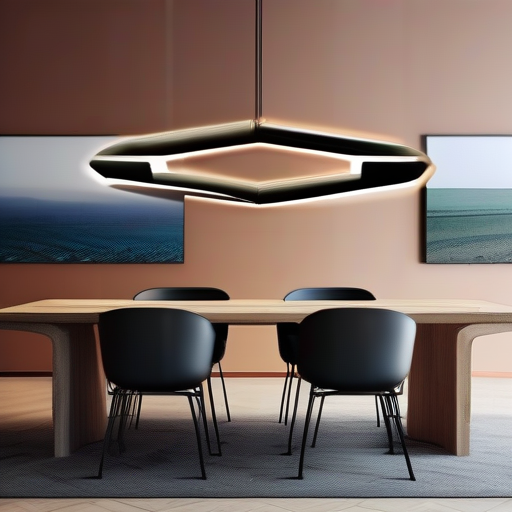

最终图片保存: final_images/final_image_1.png, 尺寸: (512, 512)
Caption: a photo of striped cats in the crown of a palm tree


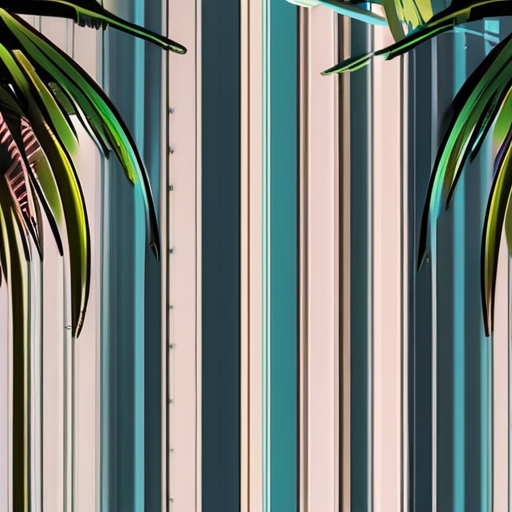

最终图片保存: final_images/final_image_2.png, 尺寸: (512, 512)
Caption: A creative and high-quality hookah with a cannonball-inspired design, featuring intricate details and a unique aesthetic


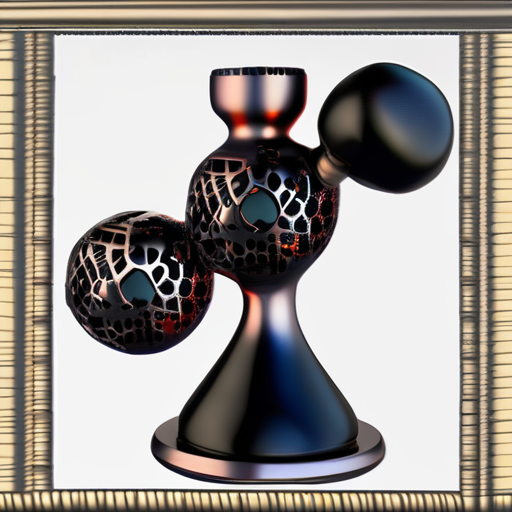

最终图片保存: final_images/final_image_3.png, 尺寸: (512, 512)
Caption: cyberpunk city, bird view


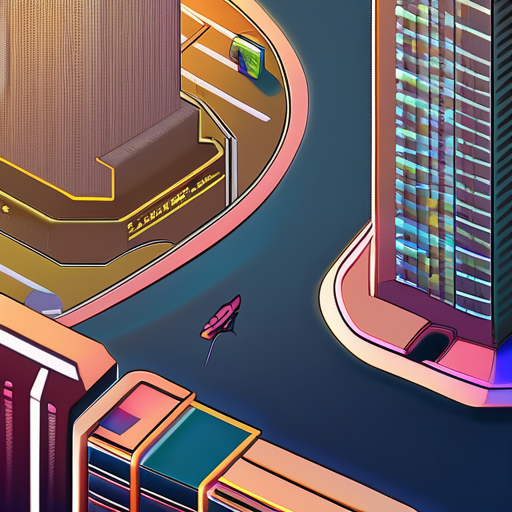

捕获到的中间步骤: [0, 5, 10, 15, 20]
正在评分步骤 0...
步骤 0 平均分数: {'aesthetics': 6.75, 'artifact': 6.875, 'alignment': 6.5, 'overall': 6.75}
正在评分步骤 5...
步骤 5 平均分数: {'aesthetics': 6.875, 'artifact': 6.875, 'alignment': 6.75, 'overall': 6.825}
正在评分步骤 10...
步骤 10 平均分数: {'aesthetics': 6.375, 'artifact': 6.875, 'alignment': 5.625, 'overall': 6.15}
正在评分步骤 15...
步骤 15 平均分数: {'aesthetics': 5.0, 'artifact': 5.0, 'alignment': 5.0, 'overall': 5.0}
正在评分步骤 20...
步骤 20 平均分数: {'aesthetics': 6.25, 'artifact': 6.5, 'alignment': 5.875, 'overall': 6.25}
可视化步骤: [0, 5, 10, 15, 20]
显示图片数量: 2
去噪过程可视化保存到: denoising_process.png


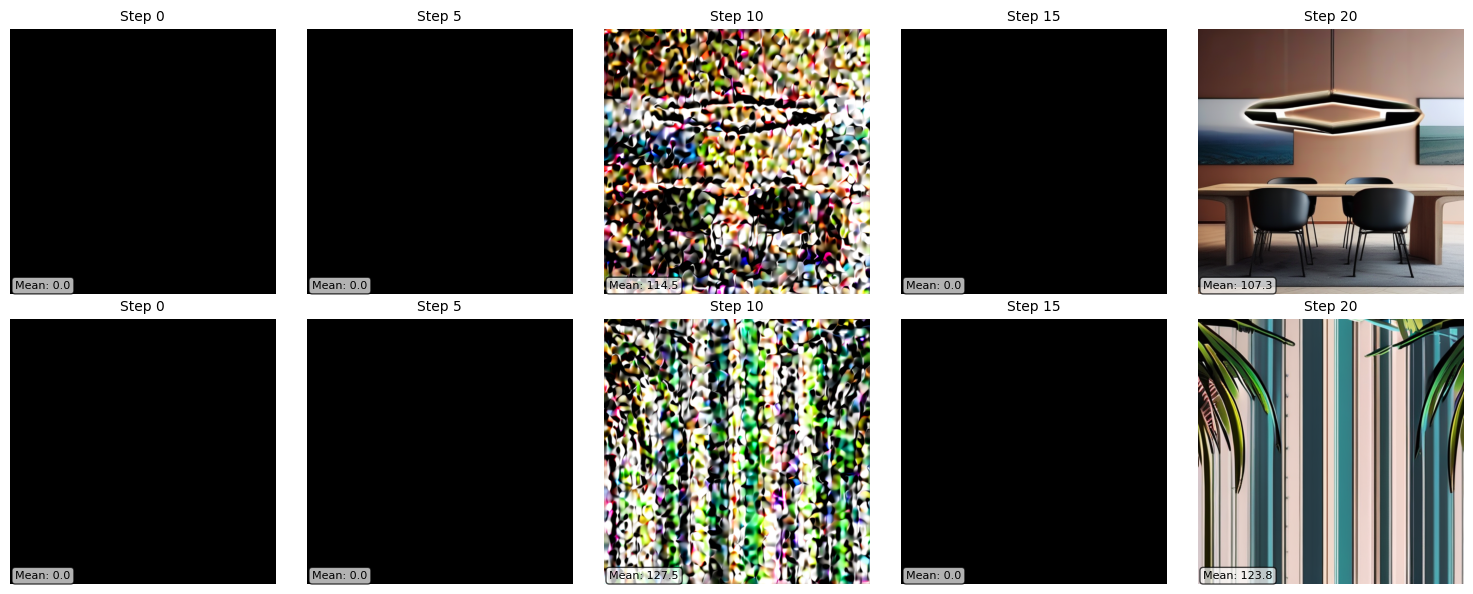

步骤 0 网格保存到: step_0_grid.png


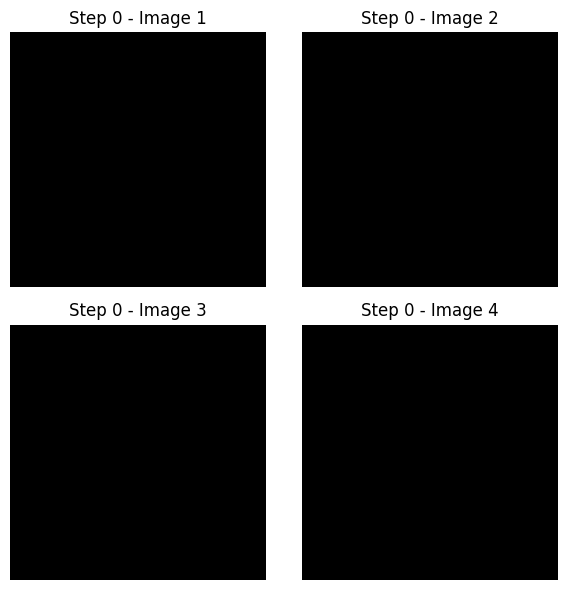

步骤 5 网格保存到: step_5_grid.png


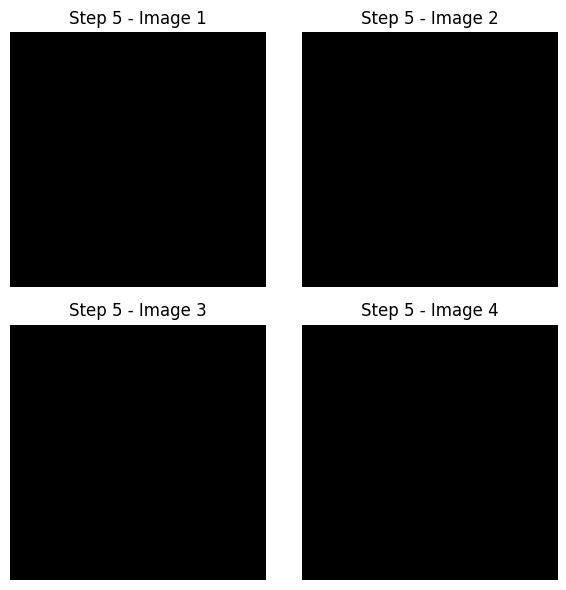

步骤 10 网格保存到: step_10_grid.png


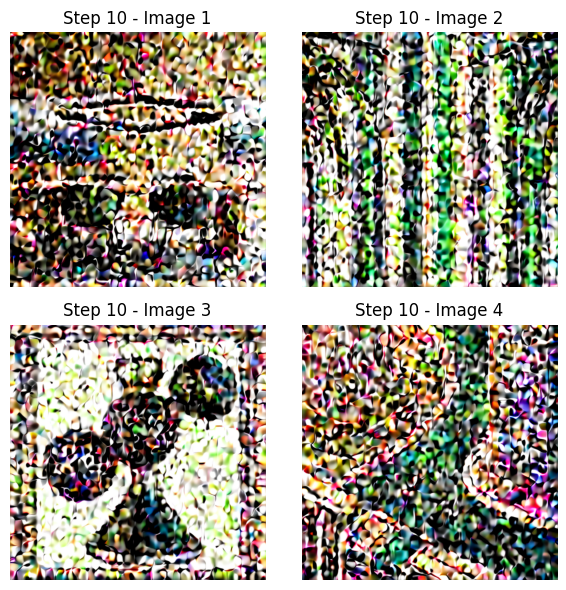

步骤 15 网格保存到: step_15_grid.png


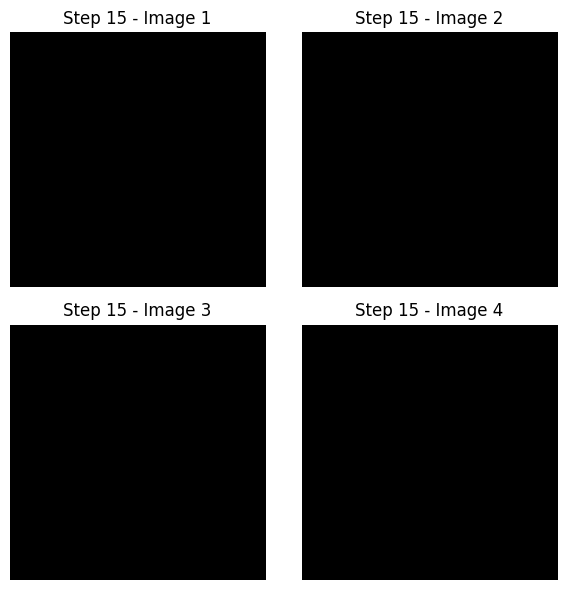

步骤 20 网格保存到: step_20_grid.png


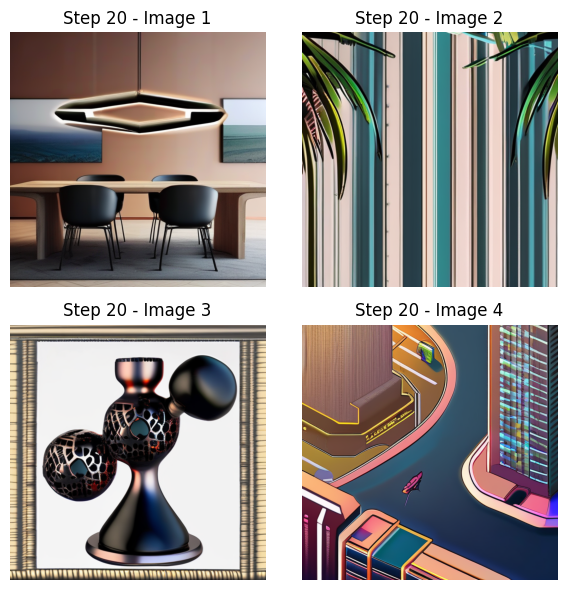

/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 39588 (\N{CJK UNIFIED IDEOGRAPH-9AA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3483112413.py:295: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}

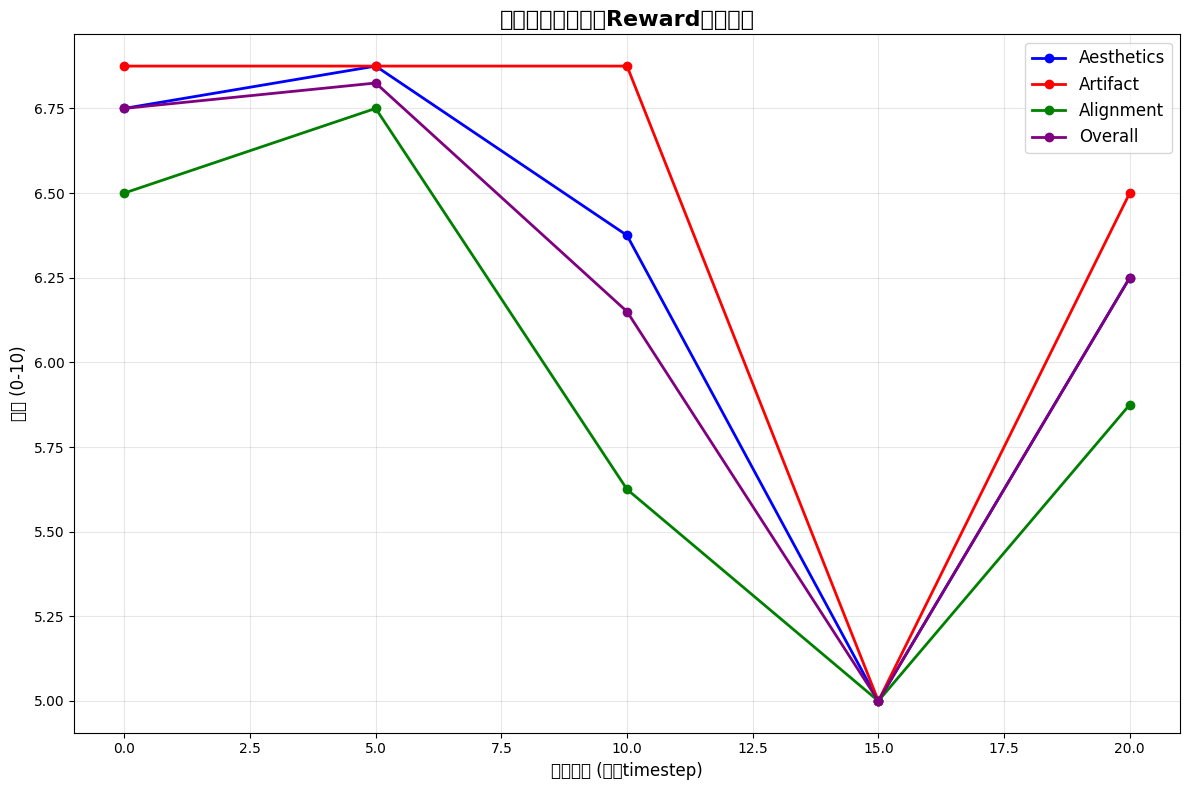

In [17]:
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionXLPipeline
from diffusers.utils import make_image_grid
import matplotlib.pyplot as plt

class DenoisingMonitor:
    """监控真实去噪过程的回调类"""
    def __init__(self, pipe, score_intervals=[0, 5, 10, 15, 20], batch_size=2):
        self.pipe = pipe
        self.score_intervals = score_intervals
        self.batch_size = batch_size
        self.intermediate_images = {}  # 存储中间图片 {step: [images]}
        self.current_captions = []
        self.current_step = 0

    def callback_on_step_end(self, pipe, step_index, timestep, callback_kwargs):
        """新版diffusers的回调函数"""

        # 获取当前的潜在表示（latents）
        latents = callback_kwargs["latents"]

        # 如果当前步骤在我们要评分的间隔中
        if step_index in self.score_intervals:
            print(f"捕获去噪步骤 {step_index}, timestep {timestep}")
            print(f"Latents shape: {latents.shape}, dtype: {latents.dtype}")
            print(f"Latents min: {latents.min():.4f}, max: {latents.max():.4f}, mean: {latents.mean():.4f}")

            # 将潜在表示解码为图片
            with torch.no_grad():
                try:
                    # 缩放latents（SDXL特定）
                    latents_scaled = latents / pipe.vae.config.scaling_factor
                    print(f"Scaled latents min: {latents_scaled.min():.4f}, max: {latents_scaled.max():.4f}")

                    # 解码为图片
                    decoded = pipe.vae.decode(latents_scaled).sample
                    print(f"Decoded shape: {decoded.shape}, min: {decoded.min():.4f}, max: {decoded.max():.4f}")

                    # 转换为PIL格式
                    images = pipe.image_processor.postprocess(decoded, output_type="pil")

                    # 立即保存图片到文件进行调试
                    import os
                    os.makedirs(f"debug_step_{step_index}", exist_ok=True)

                    for i, img in enumerate(images):
                        filename = f"debug_step_{step_index}/image_{i}.png"
                        img.save(filename)
                        print(f"保存图片: {filename}, 尺寸: {img.size}, 模式: {img.mode}")

                        # 显示图片的基本统计信息
                        img_array = np.array(img)
                        print(f"图片统计 - min: {img_array.min()}, max: {img_array.max()}, mean: {img_array.mean():.2f}")

                    # 存储中间图片
                    self.intermediate_images[step_index] = images

                    print(f"已保存步骤 {step_index} 的 {len(images)} 张图片到文件")

                except Exception as e:
                    print(f"解码步骤 {step_index} 时出错: {e}")
                    # 如果解码失败，创建一个占位符图片
                    placeholder = Image.new('RGB', (512, 512), color=(128, 128, 128))
                    self.intermediate_images[step_index] = [placeholder] * latents.shape[0]

        return callback_kwargs

def generate_with_intermediate_monitoring(pipe, captions, monitor):
    """使用回调函数生成图片并监控中间步骤"""

    print(f"开始生成 {len(captions)} 张图片，监控步骤: {monitor.score_intervals}")
    print("Captions:")
    for i, caption in enumerate(captions):
        print(f"  {i+1}: {caption}")

    # 设置回调函数
    monitor.current_captions = captions

    # 生成图片（这会触发回调函数）
    final_images = pipe(
        captions,
        num_inference_steps=20,  # 总去噪步数
        height=512,
        width=512,
        guidance_scale=7.5,
        callback_on_step_end=monitor.callback_on_step_end,  # 新版回调函数
        callback_on_step_end_tensor_inputs=["latents"],  # 指定需要传递的tensor
        return_dict=False
    )[0]

    # 保存最终图片
    print("保存最终生成的图片...")
    import os
    os.makedirs("final_images", exist_ok=True)

    for i, img in enumerate(final_images):
        filename = f"final_images/final_image_{i}.png"
        img.save(filename)
        print(f"最终图片保存: {filename}, 尺寸: {img.size}")

        # 显示最终图片
        from IPython.display import display
        print(f"Caption: {captions[i]}")
        display(img)

    # 也保存最终图片到监控器
    monitor.intermediate_images[20] = final_images

    return final_images

# 更准确的去噪评分函数
def score_intermediate_denoising_process(pipe, captions, score_intervals=[0, 5, 10, 15, 20]):
    """对真实的去噪中间过程进行评分"""

    all_scores = {
        "steps": [],
        "aesthetics": [],
        "artifact": [],
        "alignment": [],
        "overall": []
    }

    # 创建监控器
    monitor = DenoisingMonitor(pipe, score_intervals)

    # 生成图片并监控中间步骤
    final_images = generate_with_intermediate_monitoring(pipe, captions, monitor)

    print(f"捕获到的中间步骤: {list(monitor.intermediate_images.keys())}")

    # 对每个捕获的步骤进行评分
    for step in sorted(monitor.intermediate_images.keys()):
        print(f"正在评分步骤 {step}...")

        step_images = monitor.intermediate_images[step]

        # 调用GPT-4进行评分（分批处理）
        step_scores = {"aesthetics": [], "artifact": [], "alignment": [], "overall": []}

        for i in range(0, len(step_images), monitor.batch_size):
            batch_images = step_images[i:i + monitor.batch_size]
            batch_captions = captions[i:i + monitor.batch_size]

            # 使用之前定义的GPT-4评分函数
            scores = get_gpt4_scores(batch_images, batch_captions)

            # 聚合分数
            for j, (img_key, score_dict) in enumerate(scores.items()):
                for metric in ["aesthetics", "artifact", "alignment", "overall"]:
                    step_scores[metric].append(score_dict[metric])

        # 计算平均分数
        avg_scores = {}
        for metric in ["aesthetics", "artifact", "alignment", "overall"]:
            if step_scores[metric]:  # 确保列表不为空
                avg_scores[metric] = sum(step_scores[metric]) / len(step_scores[metric])
            else:
                avg_scores[metric] = 5.0  # 默认分数

        # 记录结果
        all_scores["steps"].append(step)
        for metric in ["aesthetics", "artifact", "alignment", "overall"]:
            all_scores[metric].append(avg_scores[metric])

        print(f"步骤 {step} 平均分数: {avg_scores}")

    return all_scores, monitor.intermediate_images

# 可视化中间去噪过程
def visualize_denoising_process(intermediate_images, captions, save_path="denoising_process.png"):
    """可视化去噪过程的中间步骤"""

    steps = sorted(intermediate_images.keys())
    num_images = min(len(captions), 2)  # 最多显示2张图片以节省空间

    print(f"可视化步骤: {steps}")
    print(f"显示图片数量: {num_images}")

    fig, axes = plt.subplots(num_images, len(steps), figsize=(len(steps)*3, num_images*3))

    if num_images == 1:
        axes = axes.reshape(1, -1)

    for img_idx in range(num_images):
        for step_idx, step in enumerate(steps):
            ax = axes[img_idx][step_idx]

            if step in intermediate_images and img_idx < len(intermediate_images[step]):
                img = intermediate_images[step][img_idx]
                ax.imshow(img)
                ax.set_title(f"Step {step}", fontsize=10)
                ax.axis('off')

                # 添加图片统计信息
                img_array = np.array(img)
                ax.text(0.02, 0.02, f"Mean: {img_array.mean():.1f}",
                       transform=ax.transAxes, fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
            else:
                ax.axis('off')
                ax.text(0.5, 0.5, "No Image", ha='center', va='center')

        # 在第一列添加caption
        if len(captions) > img_idx:
            caption_text = captions[img_idx][:100] + "..." if len(captions[img_idx]) > 100 else captions[img_idx]
            axes[img_idx][0].set_ylabel(f"Image {img_idx+1}:\n{caption_text}",
                                       rotation=0, ha='right', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"去噪过程可视化保存到: {save_path}")
    plt.show()

    # 额外保存每个步骤的单独图片网格
    for step in steps:
        if step in intermediate_images:
            step_images = intermediate_images[step][:4]  # 最多保存4张

            # 创建网格
            if len(step_images) > 1:
                grid_size = int(np.ceil(np.sqrt(len(step_images))))
                fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*3, grid_size*3))
                axes = axes.flatten() if grid_size > 1 else [axes]

                for i, img in enumerate(step_images):
                    axes[i].imshow(img)
                    axes[i].set_title(f"Step {step} - Image {i+1}")
                    axes[i].axis('off')

                # 隐藏多余的子图
                for i in range(len(step_images), len(axes)):
                    axes[i].axis('off')

                plt.tight_layout()
                step_save_path = f"step_{step}_grid.png"
                plt.savefig(step_save_path, dpi=300, bbox_inches='tight')
                print(f"步骤 {step} 网格保存到: {step_save_path}")
                plt.show()
            else:
                # 单张图片
                plt.figure(figsize=(6, 6))
                plt.imshow(step_images[0])
                plt.title(f"Step {step}")
                plt.axis('off')
                step_save_path = f"step_{step}_single.png"
                plt.savefig(step_save_path, dpi=300, bbox_inches='tight')
                print(f"步骤 {step} 单图保存到: {step_save_path}")
                plt.show()

# 主执行函数
def run_real_denoising_experiment(pipe, captions):
    """运行真实的去噪实验"""

    print("开始真实去噪过程实验...")

    # 选择测试用的captions（减少API调用成本）
    test_captions = captions[:4]  # 使用4个caption进行测试

    # 执行真实去噪监控和评分
    scoring_results, intermediate_images = score_intermediate_denoising_process(
        pipe,
        test_captions,
        score_intervals=[0, 5, 10, 15, 20]
    )

    # 可视化去噪过程
    visualize_denoising_process(intermediate_images, test_captions)

    # 绘制评分曲线
    plot_real_denoising_curves(scoring_results)

    return scoring_results, intermediate_images

def plot_real_denoising_curves(scoring_results):
    """绘制真实去噪过程的评分曲线"""

    plt.figure(figsize=(12, 8))

    steps = scoring_results["steps"]
    metrics = ["aesthetics", "artifact", "alignment", "overall"]
    colors = ['blue', 'red', 'green', 'purple']

    for metric, color in zip(metrics, colors):
        scores = scoring_results[metric]
        plt.plot(steps, scores, marker='o', linewidth=2,
                label=f'{metric.capitalize()}', color=color)

    plt.title('真实去噪过程中的Reward变化曲线', fontsize=16, fontweight='bold')
    plt.xlabel('去噪步骤 (真实timestep)', fontsize=12)
    plt.ylabel('评分 (0-10)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig('real_denoising_reward_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# 使用示例
# 假设你已经加载了pipe和captions

# 执行真实的去噪实验
scoring_results, intermediate_images = run_real_denoising_experiment(pipe, captions)

# 保存结果
import json
with open('real_denoising_results.json', 'w') as f:
    json.dump(scoring_results, f, indent=2)


# 用image和caption微调 用100个数据集跑通

In [23]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.5 MB/s eta 0:00:00


In [9]:
import torch
from datasets import load_dataset
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionXLPipeline
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import math
from tqdm.auto import tqdm

# --- 1. 配置参数 ---
# 训练参数
config = {
    "pretrained_model_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
    "revision": None,
    "variant": "fp16",
    "dataset_name": None, # 我们直接使用你内存中的images和captions
    "output_dir": "sdxl-finetuned-lora",
    "seed": 42,
    "resolution": 1024, # SDXL的推荐分辨率
    "center_crop": False,
    "random_flip": False,
    "train_batch_size": 1, # 根据GPU显存调整
    "num_train_epochs": 1,
    "max_train_steps": None, # 如果设置，将覆盖num_train_epochs
    "checkpointing_steps": 500, # 每隔多少步保存一次检查点
    "gradient_accumulation_steps": 4, # 梯度累积
    "gradient_checkpointing": True, # 启用梯度检查点以节省显存
    "learning_rate": 1e-4,
    "lr_scheduler": "cosine",
    "lr_warmup_steps": 100,
    "mixed_precision": "fp16", # 或 "bf16"
    "report_to": "tensorboard",
    "allow_tf32": True,
    "dataloader_num_workers": 0,
    "use_8bit_adam": True, # 如果安装了bitsandbytes可以设置为True
    "adam_beta1": 0.9,
    "adam_beta2": 0.999,
    "adam_weight_decay": 1e-2,
    "adam_epsilon": 1e-08,
    "max_grad_norm": 1.0,
    "snr_gamma": 5.0, # 用于更稳定的训练
    "lora_rank": 64, # LoRA的秩，决定了参数量
    "caption_column": "caption",
    "image_column": "image",
}

# --- 2. 自定义数据集类 ---
class CustomDataset(Dataset):
    def __init__(self, images, captions, tokenizer_1, tokenizer_2, config):
        self.images = images
        self.captions = captions
        self.tokenizer_1 = tokenizer_1
        self.tokenizer_2 = tokenizer_2
        self.config = config

        self.transform = transforms.Compose([
            transforms.Resize(config["resolution"], interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(config["resolution"]) if config["center_crop"] else transforms.RandomCrop(config["resolution"]),
            transforms.RandomHorizontalFlip() if config["random_flip"] else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]), # 归一化到[-1, 1]
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]

        # 图像预处理
        image = self.transform(image)

        # 文本预处理 (SDXL有两个文本编码器)
        token_1 = self.tokenizer_1(
            caption,
            padding="max_length",
            max_length=self.tokenizer_1.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids
        token_2 = self.tokenizer_2(
            caption,
            padding="max_length",
            max_length=self.tokenizer_2.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids

        return {
            "pixel_values": image,
            "input_ids": token_1,
            "input_ids_2": token_2,
        }

# --- 3. 训练函数 ---
def train_sdxl_lora(images, captions, config):
    accelerator = Accelerator(
        gradient_accumulation_steps=config["gradient_accumulation_steps"],
        mixed_precision=config["mixed_precision"],
        log_with=config["report_to"],
        project_dir=config["output_dir"],
    )

    # 确保输出目录存在
    if accelerator.is_main_process:
        os.makedirs(config["output_dir"], exist_ok=True)
        # accelerator.init_trackers("sdxl-lora", config=dict(config)) # 如果需要TensorBoard

    # 设置种子
    if config["seed"] is not None:
        set_seed(config["seed"])

    # 1. 加载预训练模型和分词器
    tokenizer_one = CLIPTokenizer.from_pretrained(
        config["pretrained_model_name_or_path"], subfolder="tokenizer", revision=config["revision"]
    )
    tokenizer_two = CLIPTokenizer.from_pretrained(
        config["pretrained_model_name_or_path"], subfolder="tokenizer_2", revision=config["revision"]
    )

    text_encoder_one = CLIPTextModel.from_pretrained(
        config["pretrained_model_name_or_path"], subfolder="text_encoder", revision=config["revision"]
    )
    text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
        config["pretrained_model_name_or_path"], subfolder="text_encoder_2", revision=config["revision"]
    )

    vae = AutoencoderKL.from_pretrained(
        config["pretrained_model_name_or_path"], subfolder="vae", revision=config["revision"]
    )
    unet = UNet2DConditionModel.from_pretrained(
        config["pretrained_model_name_or_path"], subfolder="unet", revision=config["revision"]
    )

    # 冻结所有模型，除了UNet
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)
    unet.requires_grad_(False)

    # 2. 启用LoRA
    from peft import LoraConfig, get_peft_model

    # LoRA配置 UNet
    lora_config_unet = LoraConfig(
        r=config["lora_rank"],
        lora_alpha=config["lora_rank"],
        init_lora_weights="gaussian",
        target_modules=["to_q", "to_k", "to_v", "to_out.0", "proj_in", "proj_out"], # 常见的LoRA目标模块
    )
    unet.add_adapter(lora_config_unet)

    # 优化器
    if config["use_8bit_adam"]:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
            )
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(), # 只优化UNet的LoRA参数
        lr=config["learning_rate"],
        betas=(config["adam_beta1"], config["adam_beta2"]),
        weight_decay=config["adam_weight_decay"],
        eps=config["adam_epsilon"],
    )

    # 调度器
    noise_scheduler = DDPMScheduler.from_pretrained(config["pretrained_model_name_or_path"], subfolder="scheduler")

    # 3. 数据加载
    train_dataset = CustomDataset(images, captions, tokenizer_one, tokenizer_two, config)
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=config["train_batch_size"],
        num_workers=config["dataloader_num_workers"],
    )

    # 学习率调度器
    lr_scheduler = get_scheduler(
        config["lr_scheduler"],
        optimizer=optimizer,
        num_warmup_steps=config["lr_warmup_steps"] * config["gradient_accumulation_steps"],
        num_training_steps=len(train_dataloader) * config["num_train_epochs"],
    )

    # 准备加速器
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    # 移动模型到GPU
    vae.to(accelerator.device)
    text_encoder_one.to(accelerator.device)
    text_encoder_two.to(accelerator.device)

    # 如果使用梯度检查点
    if config["gradient_checkpointing"]:
        unet.enable_gradient_checkpointing()

    # 4. 训练循环
    global_step = 0
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config["gradient_accumulation_steps"])
    num_training_steps = config["num_train_epochs"] * num_update_steps_per_epoch

    print(f"***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Num Epochs = {config['num_train_epochs']}")
    print(f"  Instantaneous batch size per device = {config['train_batch_size']}")
    print(f"  Total train batch size (w. parallel, distributed & accumulation) = {config['train_batch_size'] * accelerator.num_processes * config['gradient_accumulation_steps']}")
    print(f"  Gradient Accumulation steps = {config['gradient_accumulation_steps']}")
    print(f"  Total optimization steps = {num_training_steps}")

    for epoch in range(config["num_train_epochs"]):
        unet.train()
        train_loss = 0.0
        for step, batch in tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch+1}", total=len(train_dataloader)):
            with accelerator.accumulate(unet):
                # 编码图像到潜在空间
                latents = vae.encode(batch["pixel_values"].to(vae.device)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # 采样噪声
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # 加入噪声到潜在表示
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # 获取文本编码 (SDXL需要两个文本编码器)
                # 修正后的代码：
                # 1. 第一个文本编码器
                prompt_embeds = text_encoder_one(
                    batch["input_ids"].to(text_encoder_one.device), output_hidden_states=True
                ).last_hidden_state


                # 2. 第二个文本编码器
                text_encoder_two_output = text_encoder_two(
                    batch["input_ids_2"].to(text_encoder_two.device), output_hidden_states=True
                )
                prompt_embeds_2 = text_encoder_two_output.last_hidden_state
                # 修正后的代码：使用 .text_embeds 替代 .pooled_output
                pooled_prompt_embeds_2 = text_encoder_two_output.text_embeds
                # 连接文本嵌入
                text_embeds = torch.cat([prompt_embeds, prompt_embeds_2], dim=-1)

                # 将pooled_prompt_embeds_2与文本嵌入连接
                add_text_embeds = pooled_prompt_embeds_2

                # 为UNet提供额外的条件信息
                add_time_ids = torch.cat([
                    torch.tensor([batch["pixel_values"].shape[-2]], device=latents.device).float(),
                    torch.tensor([batch["pixel_values"].shape[-1]], device=latents.device).float(),
                    torch.tensor([batch["pixel_values"].shape[-2]], device=latents.device).float(),
                    torch.tensor([batch["pixel_values"].shape[-1]], device=latents.device).float(),
                    torch.tensor([0.0], device=latents.device),
                    torch.tensor([0.0], device=latents.device)
                ], dim=-1).unsqueeze(0).repeat(bsz, 1) # (bsz, 6)

                # UNet预测噪声
                model_pred = unet(
                    noisy_latents,
                    timesteps,
                    # 使用关键字参数，避免位置参数冲突
                    encoder_hidden_states=text_embeds,
                    added_cond_kwargs={
                        # pooled_prompt_embeds_2 才是正确的 text_embeds
                        "text_embeds": pooled_prompt_embeds_2,
                        "time_ids": add_time_ids
                    }
                ).sample

                # 计算损失
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
                loss = torch.nn.functional.mse_loss(model_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), config["max_grad_norm"])
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                global_step += 1
                train_loss += loss.detach().item()

                if global_step % config["checkpointing_steps"] == 0:
                    if accelerator.is_main_process:
                        # 保存LoRA权重
                        accelerator.wait_for_everyone()
                        unet_lora_path = os.path.join(config["output_dir"], f"checkpoint-{global_step}", "unet_lora.pt")
                        accelerator.save_state(unet_lora_path)
                        print(f"Saved LoRA weights for UNet at {unet_lora_path}")

            if config["max_train_steps"] is not None and global_step >= config["max_train_steps"]:
                break

        # 每个epoch结束时保存一次
        if accelerator.is_main_process:
            accelerator.wait_for_everyone()
            unet_lora_path = os.path.join(config["output_dir"], f"epoch-{epoch+1}", "unet_lora.pt")
            accelerator.save_state(unet_lora_path)
            print(f"Saved LoRA weights for UNet at {unet_lora_path} after epoch {epoch+1}")


    # 训练结束时保存最终LoRA权重
    if accelerator.is_main_process:
        accelerator.wait_for_everyone()
        unet_lora_path = os.path.join(config["output_dir"], "final_unet_lora.pt")
        accelerator.save_state(unet_lora_path)
        print(f"Final LoRA weights saved to {unet_lora_path}")

    accelerator.end_training()


# --- 4. 运行微调 ---
print("开始微调SDXL模型...")
# 假设你之前已经运行了 preprocess_data 并得到了 images 和 captions
# images, captions = preprocess_data(subset)
# 确保这里的 images 和 captions 是预处理后的PIL Image对象和字符串列表

# 为了演示，我们使用你之前的 subset 中的图片和标题
# 注意：这里会重新加载和处理数据，如果你已经有了 images 和 captions，可以直接传入
# print("正在加载数据集子集...")
# ds = load_dataset("Exploration/richhf_18k_with_images", split="train")
# random.seed(42)
# indices = random.sample(range(len(ds["train"])), 100)
# subset = ds["train"].select(indices)
# images, captions = preprocess_data(subset) # 重新调用预处理函数以确保数据格式正确

# 运行训练
train_sdxl_lora(images, captions, config)

print("SDXL模型微调完成！LoRA权重已保存。")

开始微调SDXL模型...
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 25


Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Saved LoRA weights for UNet at sdxl-finetuned-lora/epoch-1/unet_lora.pt after epoch 1
Final LoRA weights saved to sdxl-finetuned-lora/final_unet_lora.pt
SDXL模型微调完成！LoRA权重已保存。


# 微调的模型上传到仓库

In [10]:
from huggingface_hub import notebook_login
notebook_login()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [13]:
!ls

debug_step_0/          final_images/                     step_0_grid.png
debug_step_10/         real_denoising_results.json       step_10_grid.png
debug_step_15/         real_denoising_reward_curves.png  step_15_grid.png
debug_step_5/          sample_data/                      step_20_grid.png
denoising_process.png  sdxl-finetuned-lora/              step_5_grid.png


In [15]:
!ls -l sdxl-finetuned-lora/

total 8
drwxr-xr-x 3 root root 4096 Aug 26 16:42 epoch-1
drwxr-xr-x 2 root root 4096 Aug 26 16:44 final_unet_lora.pt


In [17]:
# 导入 HfApi
from huggingface_hub import HfApi

# 你的 Hugging Face 用户名
hf_username = "Logistic12"
# 你想为模型仓库取的名字
repo_name = "sdxl-richhf-100-lora_100item"

api = HfApi()

print(f"开始上传文件到仓库 {repo_name}...")

# 确保文件路径正确
lora_file_path = "sdxl-finetuned-lora/final_unet_lora.pt/model.safetensors"

# 上传文件到仓库
api.upload_file(
    path_or_fileobj=lora_file_path,
    path_in_repo="unet/adapter_model.safetensors",
    repo_id=f"{hf_username}/{repo_name}",
)


开始上传文件到仓库 sdxl-richhf-100-lora_100item...


model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

NameError: name 'your_username' is not defined

In [18]:
print(f"LoRA 权重上传成功！你可以在以下链接找到它：\nhttps://huggingface.co/{hf_username}/{repo_name}")


LoRA 权重上传成功！你可以在以下链接找到它：
https://huggingface.co/Logistic12/sdxl-richhf-100-lora_100item


# 使用微调后到模型重新绘制reward curve

正在加载 SDXL 基础模型...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

正在从本地训练状态加载 LoRA 权重...

运行真实去噪过程实验...
开始生成 4 张图片，监控步骤: [0, 5, 10, 15, 20]


  0%|          | 0/20 [00:00<?, ?it/s]

捕获去噪步骤 0, timestep 951.0


/usr/local/lib/python3.12/dist-packages/diffusers/image_processor.py:148: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


捕获去噪步骤 5, timestep 701.0
捕获去噪步骤 10, timestep 451.0
捕获去噪步骤 15, timestep 201.0
捕获到的中间步骤: [0, 5, 10, 15, 20]
正在评分步骤 0...
正在调用GPT-4o API进行评分...
步骤 0 平均分数: {'aesthetics': 8.5, 'artifact': 8.5, 'alignment': 8.5, 'overall': 8.5}
正在评分步骤 5...
正在调用GPT-4o API进行评分...
步骤 5 平均分数: {'aesthetics': 8.5, 'artifact': 8.5, 'alignment': 8.5, 'overall': 8.5}
正在评分步骤 10...
正在调用GPT-4o API进行评分...
步骤 10 平均分数: {'aesthetics': 8.5, 'artifact': 8.5, 'alignment': 8.5, 'overall': 8.5}
正在评分步骤 15...
正在调用GPT-4o API进行评分...
步骤 15 平均分数: {'aesthetics': 8.5, 'artifact': 8.75, 'alignment': 8.75, 'overall': 8.75}
正在评分步骤 20...
正在调用GPT-4o API进行评分...
步骤 20 平均分数: {'aesthetics': 9.25, 'artifact': 9.5, 'alignment': 9.75, 'overall': 9.5}

绘制评分曲线...


/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 39588 (\N{CJK UNIFIED IDEOGRAPH-9AA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352191873.py:178: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}

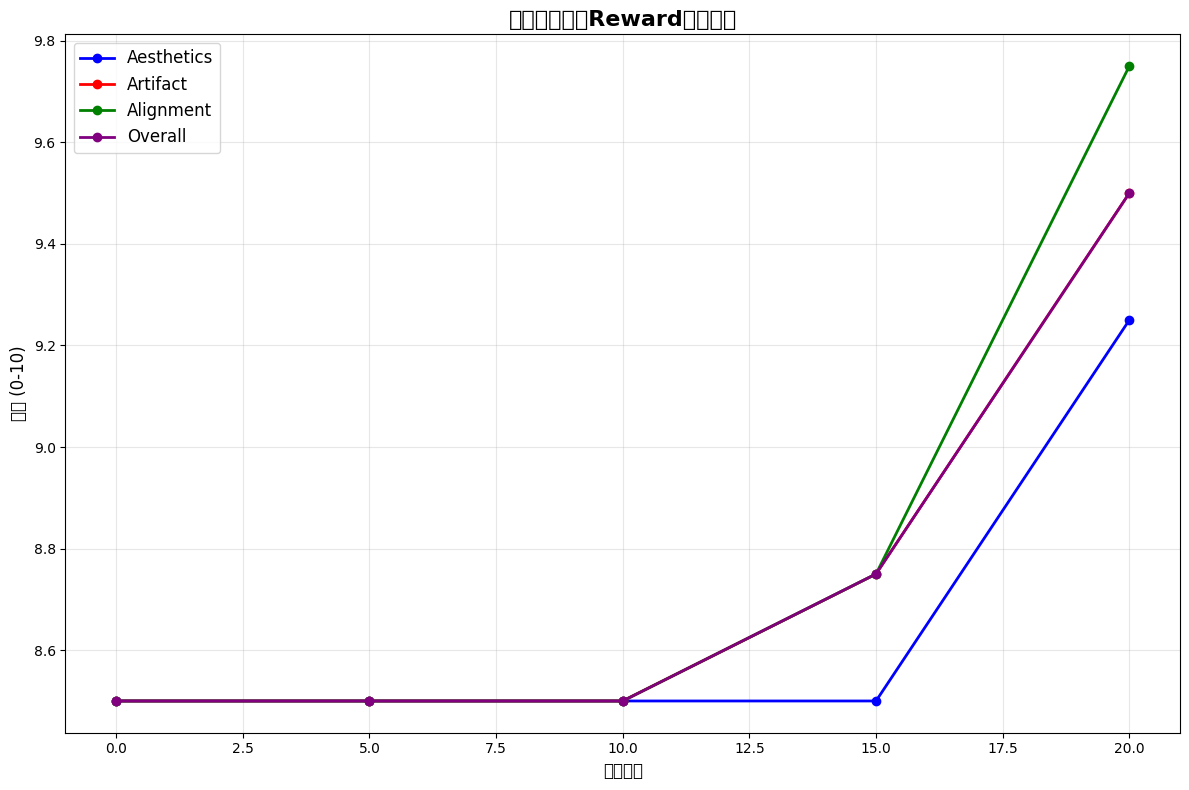

评分结果已保存到 real_denoising_results.json


In [27]:
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionXLPipeline
import matplotlib.pyplot as plt
import os
import json
import base64
from io import BytesIO
from openai import OpenAI
import time

# --- 1. 配置和初始化 ---
# 你的 Hugging Face 用户名和模型仓库名
YOUR_HF_USERNAME = "Logistic12"
YOUR_LORA_MODEL_NAME = "sdxl-richhf-100-lora_100item"
# YOUR_LORA_MODEL_NAME = "/content/sdxl-finetuned-lora/final_unet_lora.pt/model.safetensors"
# lora_model_path = f"{YOUR_HF_USERNAME}/{YOUR_LORA_MODEL_NAME}"
# lora_model_path = f"{YOUR_LORA_MODEL_NAME}"

# 设置你的 OpenAI API 密钥
# os.environ["OPENAI_API_KEY"] = "sk-..." # <-- 请在此处粘贴你的 OpenAI API Key

# 初始化 OpenAI 客户端
client = OpenAI()

# 用于将PIL图像转换为base64编码字符串
def pil_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

# --- 2. GPT-4o 评分函数 (新添加) ---
def get_gpt4_scores(images, captions):
    """
    使用GPT-4o Vision API对一批图像进行评分。
    """
    scores = {}
    print("正在调用GPT-4o API进行评分...")

    image_urls = []
    for img in images:
        base64_image = pil_to_base64(img)
        image_urls.append({"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}})

    user_message = [
        {
            "type": "text",
            "text": """
            你是一个专业的图像评估专家。请根据以下图像和对应的描述，评估它们的质量。
            请对每张图片进行以下四个维度的评分（1-10分，分数越高越好）：
            1.  **aesthetics (美学)**：图片的整体视觉吸引力，构图，色彩和氛围。
            2.  **artifact (瑕疵)**：是否有明显的图像生成瑕疵，如扭曲、模糊、重复的肢体或不协调的元素。
            3.  **alignment (对齐)**：图像内容与给定描述的匹配程度。
            4.  **overall (总体)**：基于所有维度的综合评估。

            请以 **JSON 格式**返回结果，其中键为 "image_1", "image_2" 等，值为包含四个评分的字典。请严格遵守此格式，不要添加任何其他文本。

            示例 JSON 格式:
            {
              "image_1": {
                "aesthetics": 8,
                "artifact": 9,
                "alignment": 7,
                "overall": 8
              },
              "image_2": {
                "aesthetics": 6,
                "artifact": 5,
                "alignment": 6,
                "overall": 5
              }
            }

            这是图片对应的描述:
            """ + "\n".join([f"Image {i+1}: {caption}" for i, caption in enumerate(captions)])
        }
    ]

    user_message.extend(image_urls)

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "你是一个专业的图像评估专家，只返回JSON格式的评分。"},
                {"role": "user", "content": user_message}
            ],
            response_format={"type": "json_object"},
            temperature=0.0
        )

        scores = json.loads(response.choices[0].message.content)
        return scores

    except Exception as e:
        print(f"GPT-4o API 调用出错: {e}")
        # 返回默认分数以防止中断
        default_scores = {f"image_{i+1}": {"aesthetics": 5, "artifact": 5, "alignment": 5, "overall": 5} for i in range(len(images))}
        return default_scores

# --- 3. 脚本中的其他函数 (保持不变) ---
class DenoisingMonitor:
    def __init__(self, pipe, score_intervals=[0, 5, 10, 15, 20], batch_size=2):
        self.pipe = pipe
        self.score_intervals = score_intervals
        self.batch_size = batch_size
        self.intermediate_images = {}
        self.current_captions = []
        self.current_step = 0

    def callback_on_step_end(self, pipe, step_index, timestep, callback_kwargs):
        latents = callback_kwargs["latents"]
        if step_index in self.score_intervals:
            print(f"捕获去噪步骤 {step_index}, timestep {timestep}")
            with torch.no_grad():
                try:
                    latents_scaled = 1 / pipe.vae.config.scaling_factor * latents
                    decoded = pipe.vae.decode(latents_scaled).sample
                    images = pipe.image_processor.postprocess(decoded, output_type="pil")
                    self.intermediate_images[step_index] = images
                except Exception as e:
                    print(f"解码步骤 {step_index} 时出错: {e}")
                    placeholder = Image.new('RGB', (1024, 1024), color=(128, 128, 128))
                    self.intermediate_images[step_index] = [placeholder] * latents.shape[0]
        return callback_kwargs

def generate_with_intermediate_monitoring(pipe, captions, monitor):
    print(f"开始生成 {len(captions)} 张图片，监控步骤: {monitor.score_intervals}")
    monitor.current_captions = captions
    final_images = pipe(
        captions,
        num_inference_steps=20,
        height=1024,
        width=1024,
        guidance_scale=7.5,
        callback_on_step_end=monitor.callback_on_step_end,
        callback_on_step_end_tensor_inputs=["latents"],
        return_dict=False
    )[0]
    monitor.intermediate_images[20] = final_images
    return final_images

def score_intermediate_denoising_process(pipe, captions, score_intervals=[0, 5, 10, 15, 20]):
    all_scores = {"steps": [], "aesthetics": [], "artifact": [], "alignment": [], "overall": []}
    monitor = DenoisingMonitor(pipe, score_intervals)
    final_images = generate_with_intermediate_monitoring(pipe, captions, monitor)
    print(f"捕获到的中间步骤: {list(monitor.intermediate_images.keys())}")
    for step in sorted(monitor.intermediate_images.keys()):
        print(f"正在评分步骤 {step}...")
        step_images = monitor.intermediate_images[step]
        step_scores = {"aesthetics": [], "artifact": [], "alignment": [], "overall": []}
        scores = get_gpt4_scores(step_images, captions)
        for i, (img_key, score_dict) in enumerate(scores.items()):
            for metric in ["aesthetics", "artifact", "alignment", "overall"]:
                step_scores[metric].append(score_dict.get(metric, 5))
        avg_scores = {metric: sum(step_scores[metric]) / len(step_scores[metric]) if step_scores[metric] else 5.0 for metric in step_scores}
        all_scores["steps"].append(step)
        for metric in ["aesthetics", "artifact", "alignment", "overall"]:
            all_scores[metric].append(avg_scores.get(metric, 5.0))
        print(f"步骤 {step} 平均分数: {avg_scores}")
    return all_scores, monitor.intermediate_images

def plot_real_denoising_curves(scoring_results):
    plt.figure(figsize=(12, 8))
    steps = scoring_results["steps"]
    metrics = ["aesthetics", "artifact", "alignment", "overall"]
    colors = ['blue', 'red', 'green', 'purple']
    for metric, color in zip(metrics, colors):
        scores = scoring_results[metric]
        plt.plot(steps, scores, marker='o', linewidth=2, label=f'{metric.capitalize()}', color=color)
    plt.title('去噪过程中的Reward变化曲线', fontsize=16, fontweight='bold')
    plt.xlabel('去噪步骤', fontsize=12)
    plt.ylabel('评分 (0-10)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# import torch
# import numpy as np
# from PIL import Image
# from diffusers import StableDiffusionXLPipeline
# import matplotlib.pyplot as plt
# import os
# import json
# import base64
# from io import BytesIO
# from openai import OpenAI
# from accelerate import Accelerator

# ... [The rest of your code, including DenoisingMonitor, get_gpt4_scores, etc., remains the same] ...

# --- 4. 主执行部分 ---
if __name__ == "__main__":
    # 1. 定义本地 LoRA 权重路径
    local_lora_path = "/content/sdxl-finetuned-lora/final_unet_lora.pt" # <-- 注意：这里是目录路径

    print("正在加载 SDXL 基础模型...")

    # 2. 加载基础模型
    base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
    pipe = StableDiffusionXLPipeline.from_pretrained(base_model_path, torch_dtype=torch.float16)

    # 3. 加载你的 LoRA 权重
    print("正在从本地训练状态加载 LoRA 权重...")

    # 使用 Accelerator 来加载整个训练状态
    accelerator = Accelerator()
    accelerator.load_state(local_lora_path)

    # 从加载的状态中提取 LoRA 权重
    unet_lora_state_dict = accelerator.get_state_dict(accelerator.unwrap_model(pipe.unet))

    # 将提取的 LoRA 权重直接设置到 pipeline 中
    pipe.unet.load_state_dict(unet_lora_state_dict, strict=False)

    # 4. 将模型移到 GPU
    pipe.to("cuda")

    # 5. 定义测试用的 Prompt
    test_captions = [
        "A high-quality image of a ferrari car, made out of different materials, professional photography",
        "A cyberpunk cat, with neon-lights and futuristic armor, detailed illustration",
        "A bowl of ramen, with steam rising, photorealistic, cinematic lighting",
        "A cozy living room with a fireplace, warm light, soft colors, studio ghibli style"
    ]

    # 6. 运行实验
    print("\n运行真实去噪过程实验...")
    scoring_results, _ = score_intermediate_denoising_process(pipe, test_captions)

    # 7. 绘制结果
    print("\n绘制评分曲线...")
    plot_real_denoising_curves(scoring_results)

    # 8. 保存结果
    with open('real_denoising_results.json', 'w') as f:
        json.dump(scoring_results, f, indent=2)
    print("评分结果已保存到 real_denoising_results.json")